In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [4]:
filepath = '../data'

In [5]:
full_df_bin = pd.read_csv(f'{filepath}/all_sims_binary_outcomes.csv')
full_df_nan = pd.read_csv(f'{filepath}/all_sims_nan.csv')

In [6]:
def get_plot_df(full_df, covs, t_setting, t_drop_setting, dgp, binary_dose):
    keep_rows = pd.Series([True]*full_df.shape[0])
    if covs is not None:
        keep_rows = keep_rows & (full_df['Covs'] == covs)
    if t_setting is not None:
        keep_rows = keep_rows & (full_df['T Setting'] == t_setting)
    if t_drop_setting is not None:
        keep_rows = keep_rows & (full_df['T Drop Setting'] == t_drop_setting)
    if dgp is not None:
        keep_rows = keep_rows & (full_df['DGP'] == dgp)
    if binary_dose is not None:
        keep_rows = keep_rows & (full_df['Binary Dose'] == binary_dose)

    return full_df[keep_rows]

def get_median_val(this_df, col):
    return this_df[col].median()*100

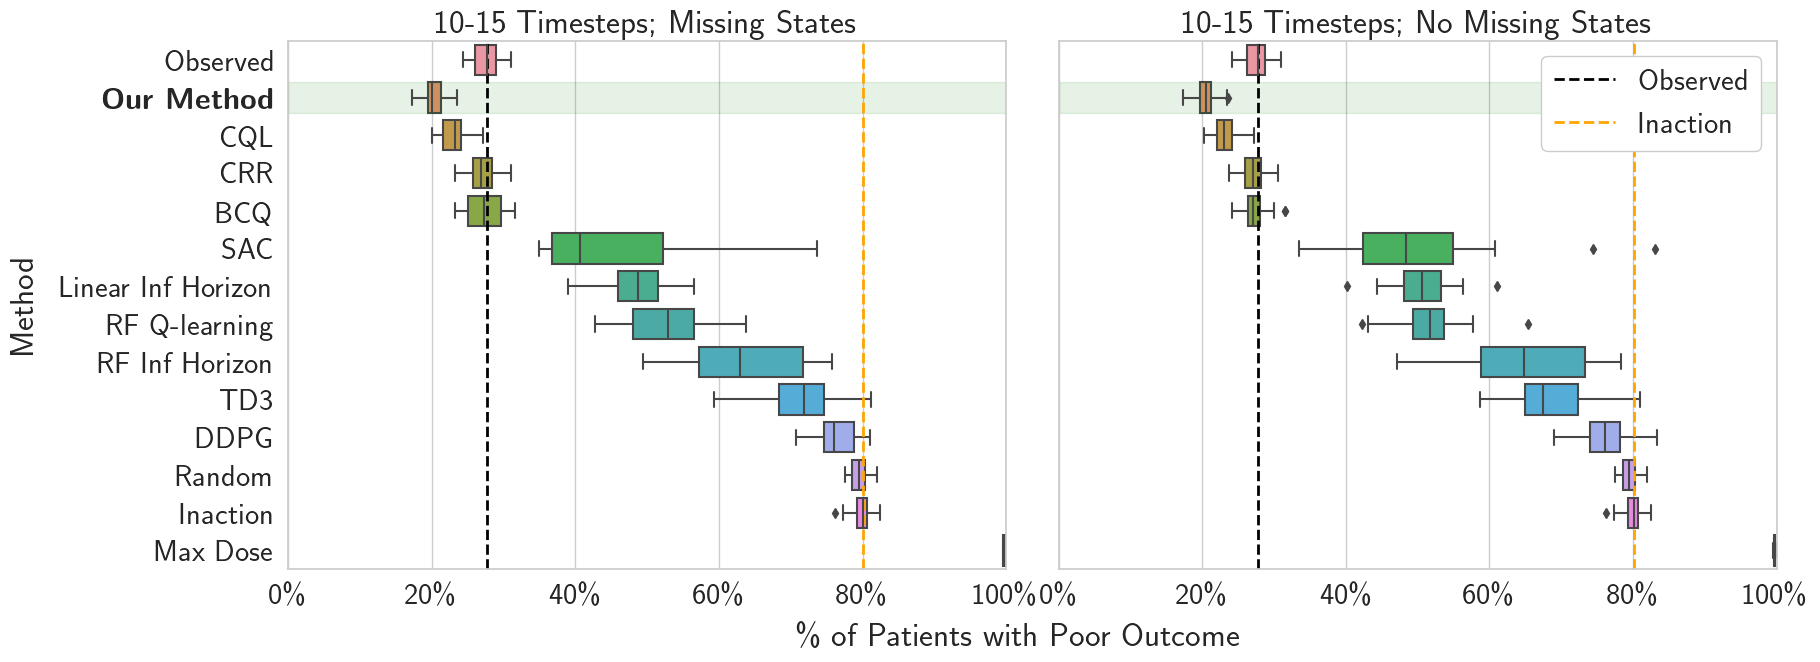

In [7]:
# Figure 1

covs = 100
binary_dose = False
dgp = 'informed'
t_setting = 'b'

rename = {
    'Our Method': r'$\textbf{Our Method}$',
    'Linear Inf Multi R2': 'Linear Inf Horizon', 
    'RF Inf Multi R2': 'RF Inf Horizon',
    'Linear Q-learning Multi': 'Linear Q-learning',
    'RF Q-learning Multi': 'RF Q-learning',
    'CQL R2': 'CQL',
    'CRR R2': 'CRR',
    'BCQ R2': 'BCQ',
    'Linear Q-learning Multi': 'Linear Q-learning',
    'SAC R2': 'SAC',
    'TD3 R2': 'TD3',
    'DDPG R2': 'DDPG',
    'Full Dosing': 'Max Dose'
    
}

methods = ['Observed', r'$\textbf{Our Method}$', 'CQL', 'CRR', 'BCQ', 'Linear Inf Horizon', 'RF Q-learning', 
           'RF Inf Horizon',  'SAC', 'TD3', 'DDPG', 'Random', 'Inaction', 'Max Dose']


mpl.rcParams.update(mpl.rcParamsDefault)
sns.set(style='whitegrid', font_scale=2, rc={'text.usetex' : True})
fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=True, sharex=True)
d = 0
for t_drop_setting in ['b', 'a']:
    title = '10-15 Timesteps; '
    title = title + ('No' if t_drop_setting == 'a' else '')
    title = title + ' Missing States'
    this_df = get_plot_df(full_df_bin, covs, t_setting, t_drop_setting, dgp, binary_dose)
    obs_med, inact_med = get_median_val(this_df, 'Observed'), get_median_val(this_df, 'Inaction')
    this_df = this_df.rename(columns=rename)
    this_df = this_df[methods]
    this_df *= 100
    first_base_methods = [c for c in ['Observed', 'Expert', r'$\textbf{Our Method}$'] if c in methods]
    last_base_methods = [c for c in ['Random', 'Inaction', 'Max Dose'] if c in methods]
    if d == 0:
        order = list(this_df[[m for m in methods if m not in first_base_methods + last_base_methods]].median().sort_values().index)
        order = first_base_methods + order + last_base_methods
    this_df = this_df[order]
    p = sns.boxplot(data=this_df, orient='h', ax=ax[d])
    ax[d].set_ylabel('')
    ax[d].set_title(title)
    ax[d].axvline(x=obs_med, color='black', linestyle='--', label='Observed', linewidth=2)
    ax[d].axvline(x=inact_med, color='orange', linestyle='--', label='Inaction', linewidth=2)
    ax[d].set_xlim([0, 100])
    ax[d].xaxis.set_major_formatter(mtick.PercentFormatter())
    d += 1

ax[0].set_ylabel('Method', fontsize=24)
ax[0].yaxis.labelpad = 15
fig.text(0.56, -0.06, '\% of Patients with Poor Outcome', ha='center')
ax[1].legend(loc='upper right', facecolor='white', framealpha=1)

for i in range(2):
    ax[i].axhspan(1-0.4,1+0.4, color='green', alpha=0.1)

plt.tight_layout(pad=0) 
plt.savefig(f'{filepath}/main_plot_full.png', bbox_inches="tight")    
plt.show()

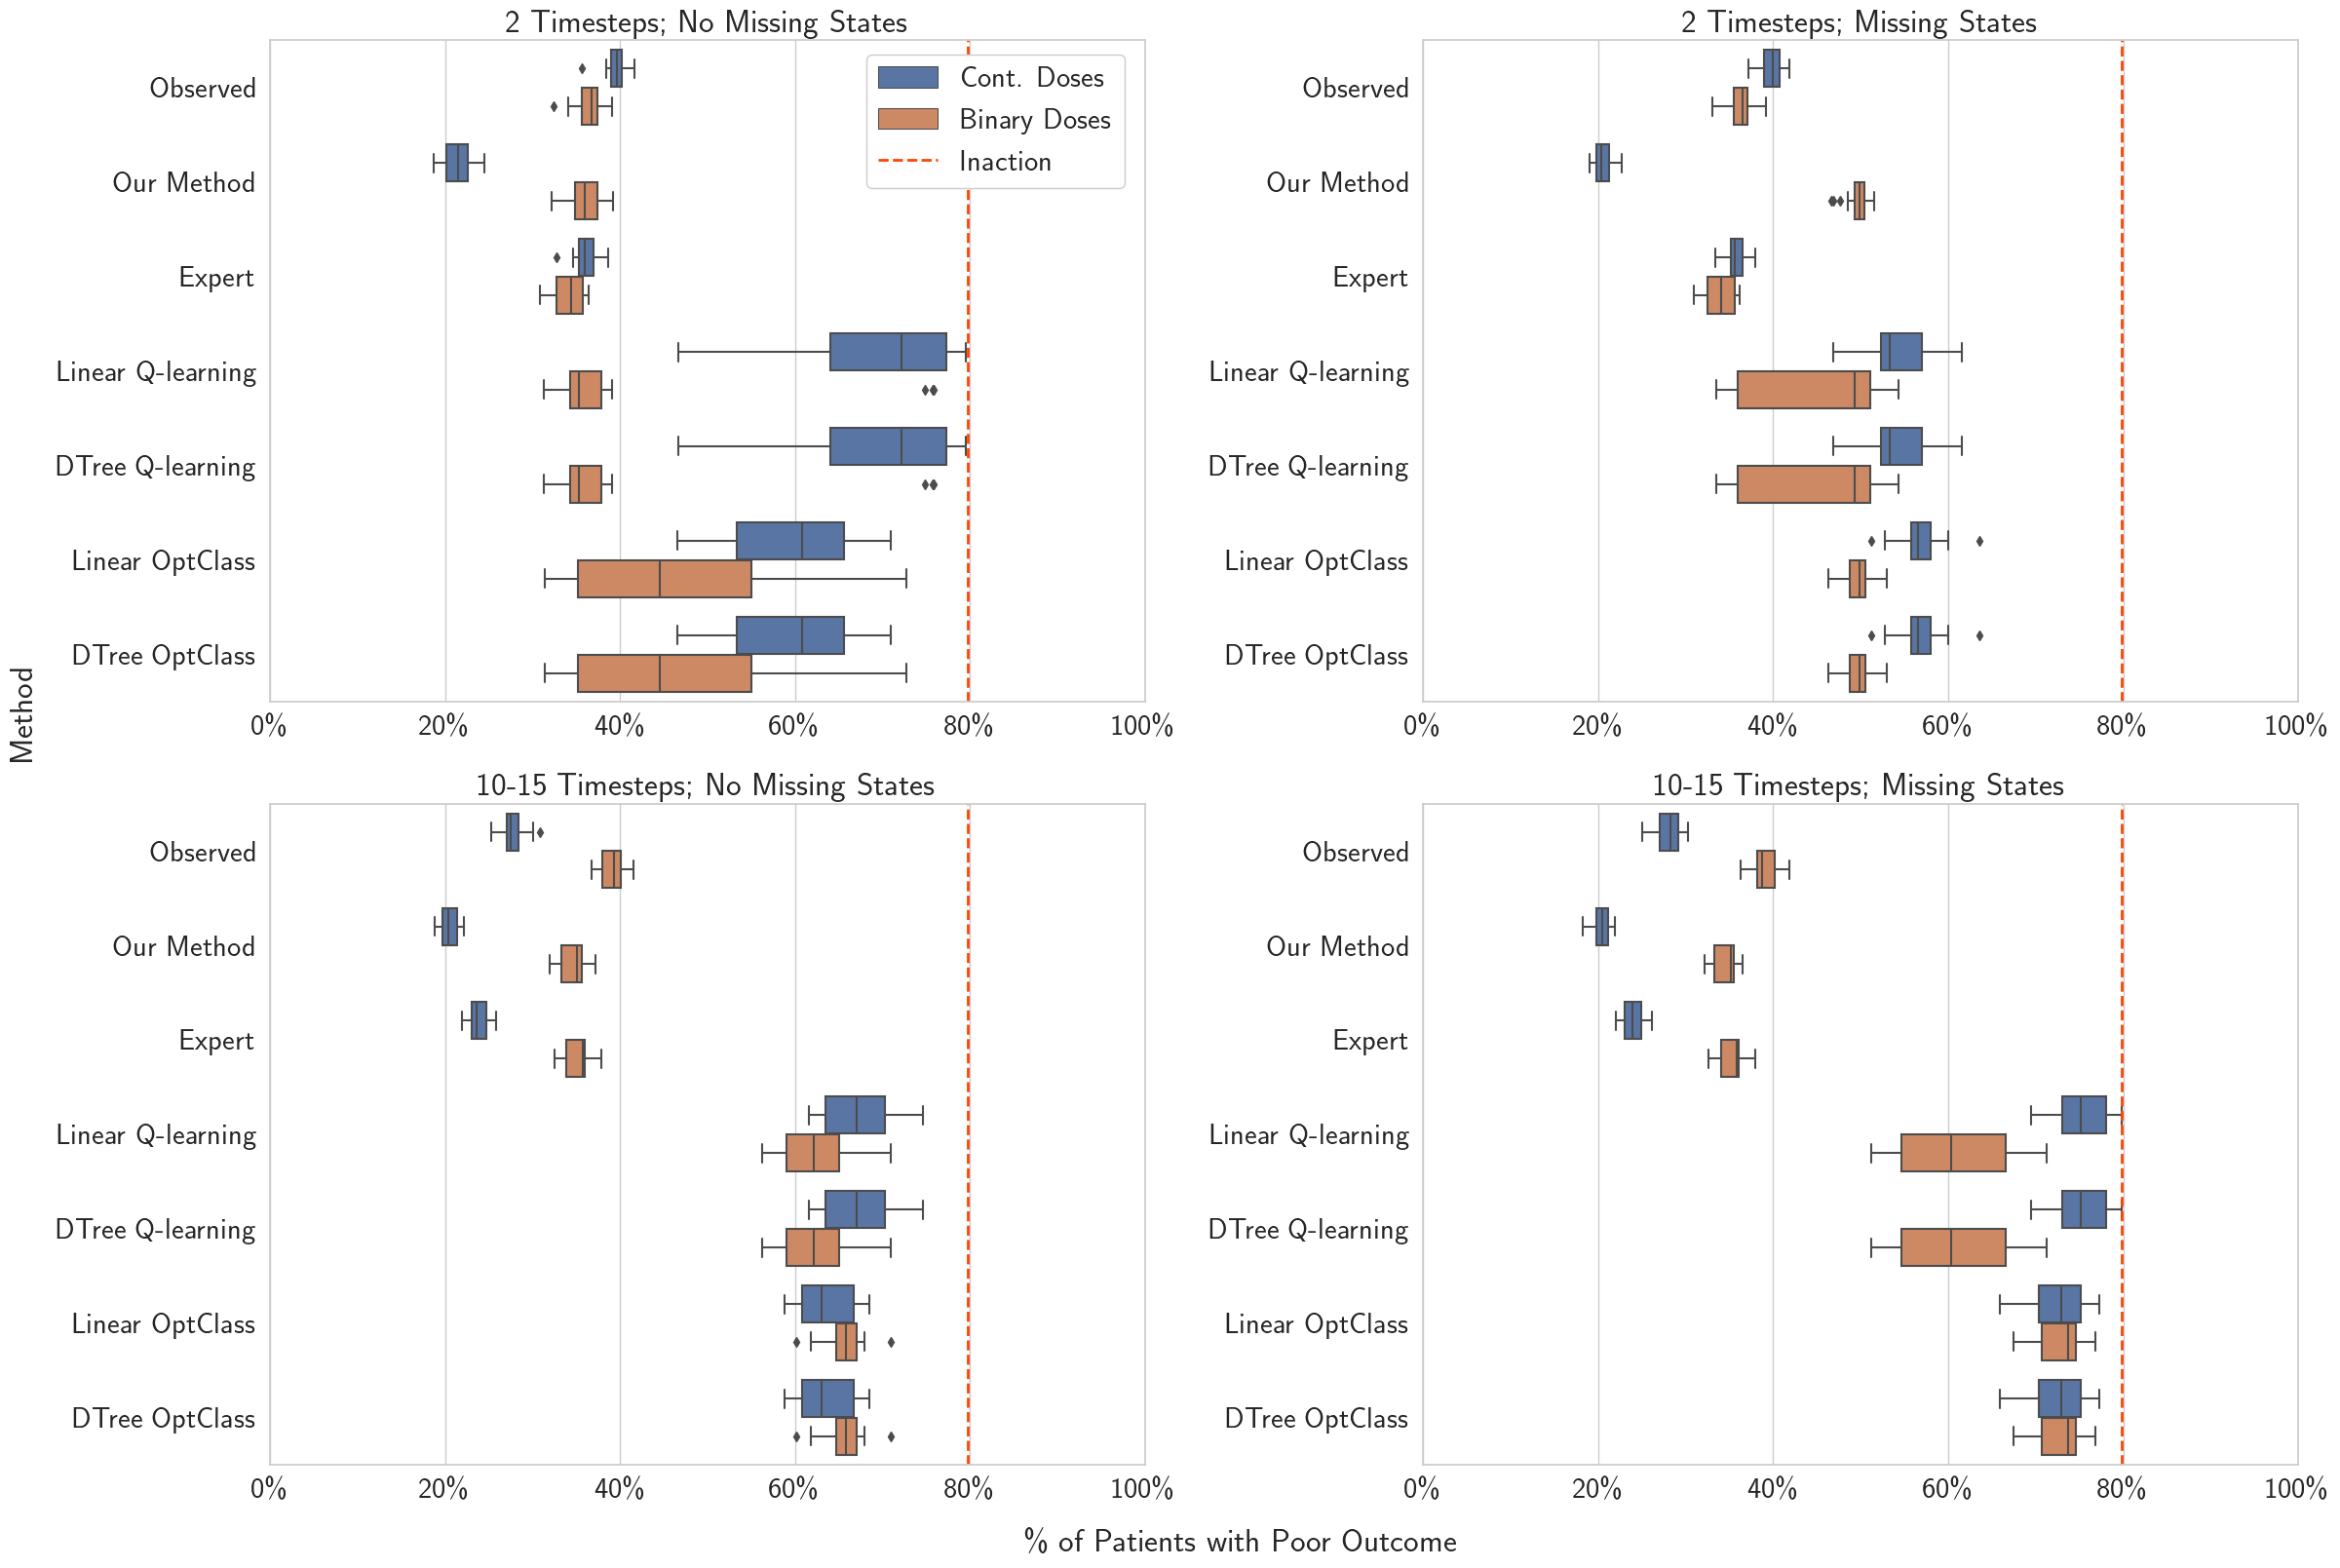

In [8]:
# Figure 5 in Appendix

sim = None
covs = 10
dgp = 'informed'


rename = {'Linear Q-learning (R)': 'Linear Q-learning', 
          'DTree Q-learning (R)': 'DTree Q-learning'}
methods = ['Binary Dose', 'Observed', 'Our Method', 'Expert', 
           'Linear Q-learning', 'DTree Q-learning', 'Linear OptClass', 'DTree OptClass']


sns.set(style='whitegrid', font_scale=2)
fig, ax = plt.subplots(2, 2, figsize=(24, 16))
v = 0
for t_drop_setting in ['a', 'b']:
    u = 0
    for t_setting in ['a', 'b']:
        title = '2' if t_setting == 'a' else '10-15'
        title = title + ' Timesteps; '
        title = title + ('No' if t_drop_setting == 'a' else '')
        title = title + ' Missing States'
        
        this_df = get_plot_df(full_df_bin, covs, t_setting, t_drop_setting, dgp, binary_dose=None)
        inact_med = get_median_val(this_df, 'Inaction')
        this_df = this_df.rename(columns=rename)
        this_df = this_df.sort_values('Binary Dose', ascending=False)[methods].melt(id_vars=['Binary Dose'])
        this_df['value'] *= 100
        p = sns.boxplot(data=this_df, x='value', y='variable', orient='h', ax=ax[u,v], hue='Binary Dose')
        ax[u,v].set_xlabel('')
        ax[u,v].set_ylabel('')
        ax[u,v].set_title(title)
        ax[u,v].axvline(x=inact_med, color='orangered', linestyle='--', label='Inaction', linewidth=2)
        ax[u,v].set_xlim([0, 100])
        ax[u,v].xaxis.set_major_formatter(mtick.PercentFormatter())
        handles, labels = ax[u,v].get_legend_handles_labels()
        ax[u,v].get_legend().remove()
        u += 1
    v += 1


fig.text(0, 0.5, 'Method', ha='center', rotation=90)
fig.text(0.52, -0.01, '\% of Patients with Poor Outcome', ha='center')
fig.legend(handles, ['Cont. Doses', 'Binary Doses', 'Inaction'], loc=(0.37, 0.88), facecolor='white', framealpha=1)


plt.tight_layout(pad=1.0) 
plt.savefig(f'{filepath}/binary_comp1.png', bbox_inches="tight")    
plt.show()

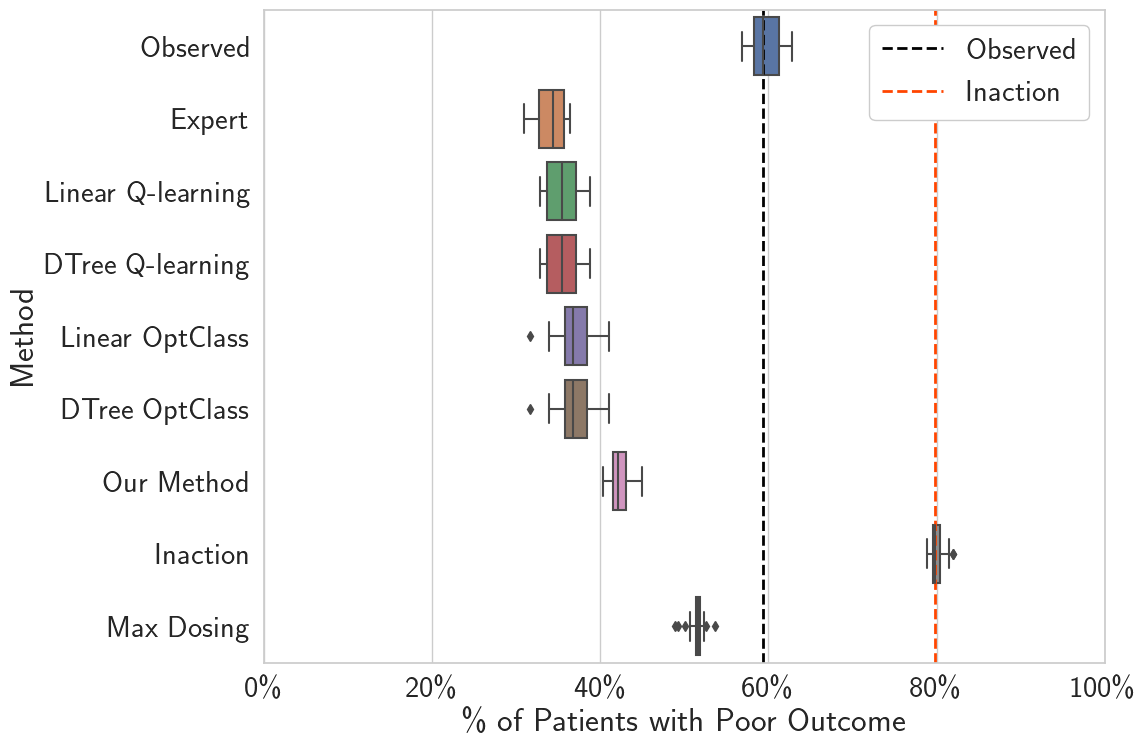

In [9]:
# Figure 6 in Appendix

covs = 10
t_setting = 'a'
t_drop_setting = 'a'
dgp = 'random'
binary_dose = True


rename = {'Linear Q-learning (R)': 'Linear Q-learning', 
          'DTree Q-learning (R)': 'DTree Q-learning',
          'Full Dosing': 'Max Dosing'}
methods = ['Observed', 'Our Method', 'Expert', 
           'Linear Q-learning', 'DTree Q-learning', 'Linear OptClass', 'DTree OptClass',
           'Inaction', 'Max Dosing']

this_df = get_plot_df(full_df_bin, covs, t_setting, t_drop_setting, dgp, binary_dose)
obs_med, inact_med = get_median_val(this_df, 'Observed'), get_median_val(this_df, 'Inaction')
this_df = this_df.rename(columns=rename)[methods]
first_base_methods = [c for c in ['Observed', 'Expert'] if c in methods]
last_base_methods = [c for c in ['Random', 'Inaction', 'Max Dosing'] if c in methods]
order = list(this_df[[m for m in methods if m not in first_base_methods + last_base_methods]].median().sort_values().index)
order = first_base_methods + order + last_base_methods
this_df = this_df[order]
this_df *= 100

sns.set(style='whitegrid', font_scale=2)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
p = sns.boxplot(data=this_df, orient='h', ax=ax)
ax.axvline(x=obs_med, color='black', linestyle='--', label='Observed', linewidth=2)
ax.axvline(x=inact_med, color='orangered', linestyle='--', label='Inaction', linewidth=2)
ax.set_xlim([0, 100])
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel('\% of Patients with Poor Outcome')
ax.set_ylabel('Method')        
plt.legend(loc='upper right', facecolor='white', framealpha=1)
plt.tight_layout()
plt.savefig(f'{filepath}/binary_sanity.png', bbox_inches="tight")
plt.show()


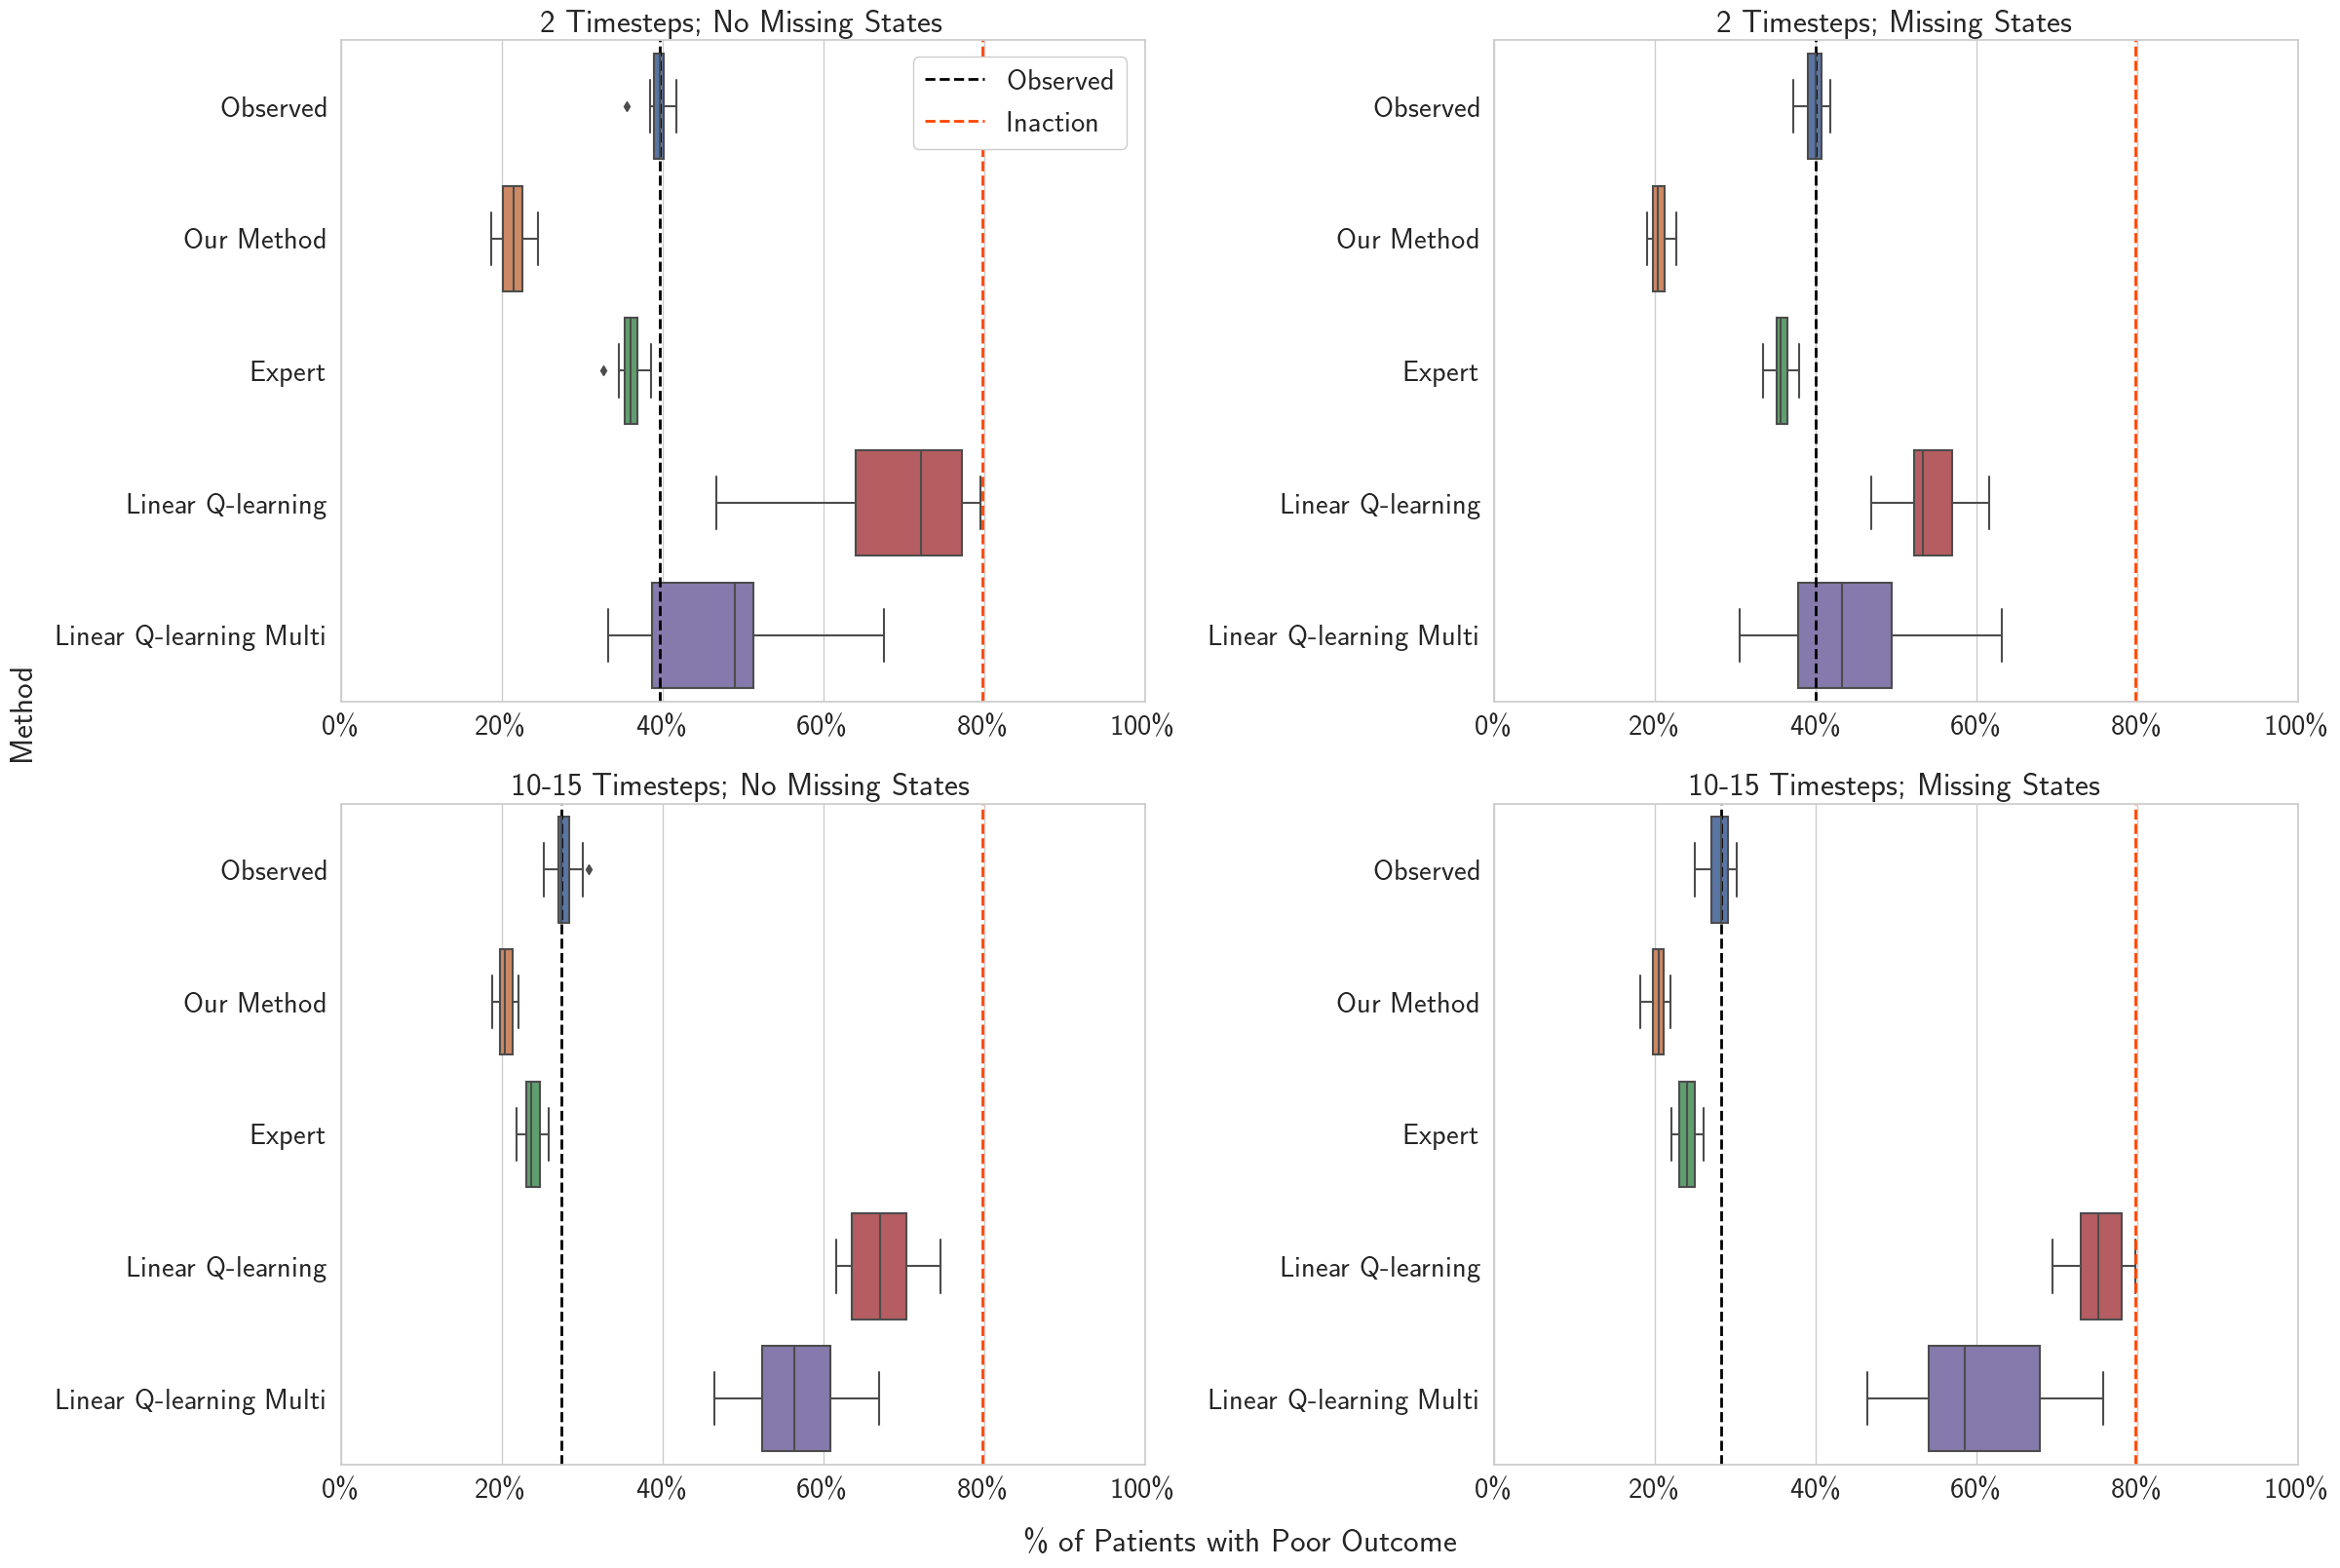

In [10]:
# Figure 7 in Appendix

covs = 10
binary_dose = False
dgp = 'informed'

rename = {'Linear Q-learning (R)': 'Linear Q-learning'}
methods = ['Observed', 'Our Method', 'Expert', 'Linear Q-learning', 'Linear Q-learning Multi']


sns.set(style='whitegrid', font_scale=2)
fig, ax = plt.subplots(2, 2, figsize=(24, 16))
v = 0
for t_drop_setting in ['a', 'b']:
    u = 0
    for t_setting in ['a', 'b']:
        title = '2' if t_setting == 'a' else '10-15'
        title = title + ' Timesteps; '
        title = title + ('No' if t_drop_setting == 'a' else '')
        title = title + ' Missing States'
        
        this_df = get_plot_df(full_df_bin, covs, t_setting, t_drop_setting, dgp, binary_dose)
        obs_med, inact_med = get_median_val(this_df, 'Observed'), get_median_val(this_df, 'Inaction')
        this_df = this_df.rename(columns=rename)[methods].melt()
        this_df['value'] *= 100
        p = sns.boxplot(data=this_df, x='value', y='variable', orient='h', ax=ax[u,v])
        ax[u,v].set_xlabel('')
        ax[u,v].set_ylabel('')
        ax[u,v].set_title(title)
        ax[u,v].axvline(x=obs_med, color='black', linestyle='--', label='Observed', linewidth=2)
        ax[u,v].axvline(x=inact_med, color='orangered', linestyle='--', label='Inaction', linewidth=2)
        ax[u,v].set_xlim([0, 100])
        ax[u,v].xaxis.set_major_formatter(mtick.PercentFormatter())
        handles, labels = ax[u,v].get_legend_handles_labels()
        u += 1
    v += 1


fig.text(0, 0.5, 'Method', ha='center', rotation=90)
fig.text(0.52, -0.01, '\% of Patients with Poor Outcome', ha='center')
fig.legend(handles, ['Observed', 'Inaction'], loc=(0.39, 0.905), facecolor='white', framealpha=1)


plt.tight_layout(pad=1.0) 
plt.savefig(f'{filepath}/binary_vs_multi_comp.png', bbox_inches="tight")    
plt.show()

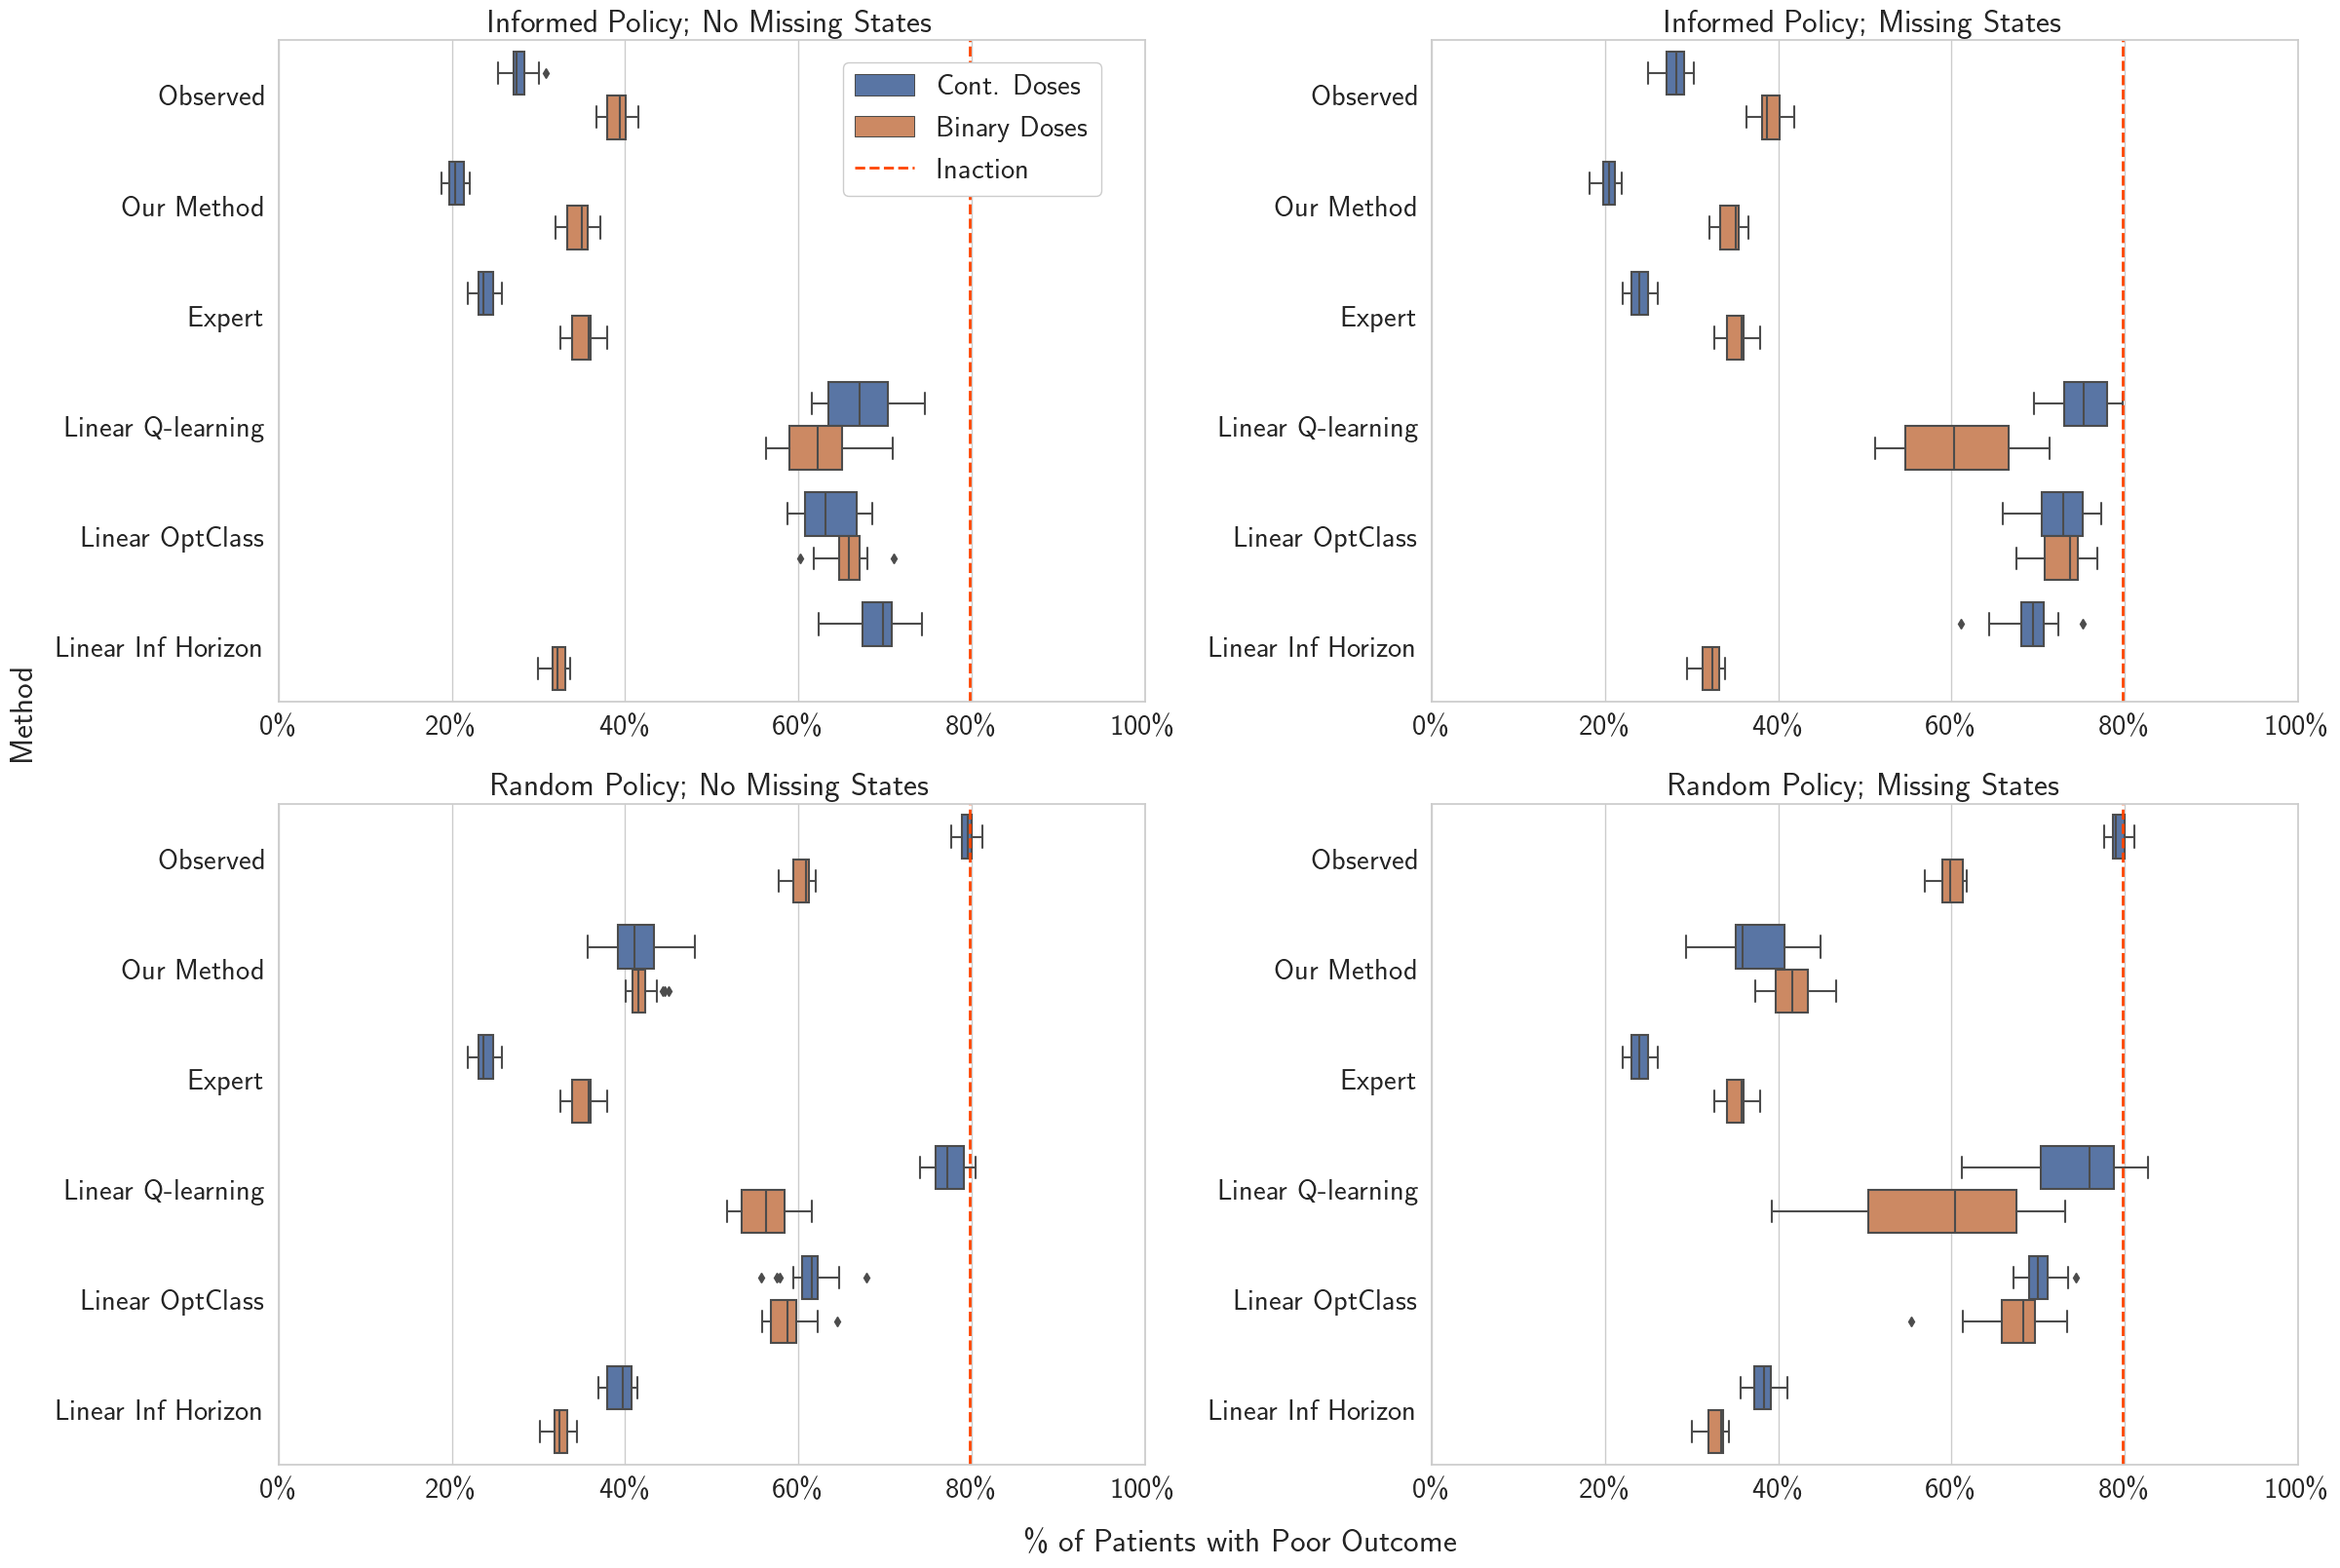

In [11]:
# Figure 8 in Appendix

covs = 10
t_setting = 'b'

rename = {'Linear Q-learning (R)': 'Linear Q-learning',
         'Linear Inf R3': 'Linear Inf Horizon'}
methods = ['Binary Dose', 'Observed', 'Our Method', 'Expert', 
           'Linear Q-learning', 'Linear OptClass', 'Linear Inf Horizon']


sns.set(style='whitegrid', font_scale=2)
fig, ax = plt.subplots(2, 2, figsize=(24, 16))
d = 0
for dgp in ['informed', 'random']:
    t = 0
    while t < 2:
        if t == 0:
            t_drop_setting = 'a' # 1 is [2,2], 2 is [10,15]
            title = dgp.capitalize()
            title = title + ' Policy; No Missing States'
        else:
            t_drop_setting = 'b'
            title = dgp.capitalize()
            title = title + ' Policy; Missing States'
        this_df = get_plot_df(full_df_bin, covs, t_setting, t_drop_setting, dgp, binary_dose=None)
        inact_med = get_median_val(this_df, 'Inaction')
        this_df = this_df.rename(columns=rename)
        this_df = this_df.sort_values('Binary Dose', ascending=False)[methods].melt(id_vars=['Binary Dose'])
        this_df['value'] *= 100
        p = sns.boxplot(data=this_df, x='value', y='variable', orient='h', ax=ax[d,t], hue='Binary Dose')
        ax[d,t].set_xlabel('')
        ax[d,t].set_ylabel('')
        ax[d,t].set_title(title)
        ax[d,t].axvline(x=inact_med, color='orangered', linestyle='--', label='Inaction', linewidth=2)
        ax[d,t].set_xlim([0, 100])
        ax[d,t].xaxis.set_major_formatter(mtick.PercentFormatter())
        handles, labels = ax[d,t].get_legend_handles_labels()      
        ax[d,t].get_legend().remove()
        t += 1
    d += 1

fig.text(0, 0.5, 'Method', ha='center', rotation=90)
fig.text(0.52, -0.01, '\% of Patients with Poor Outcome', ha='center')
fig.legend(handles, ['Cont. Doses', 'Binary Doses', 'Inaction'], loc=(0.36, 0.875), facecolor='white', framealpha=1)


plt.tight_layout(pad=1.0) 
plt.savefig(f'{filepath}/inf_vs_finite.png', bbox_inches="tight")    
plt.show()

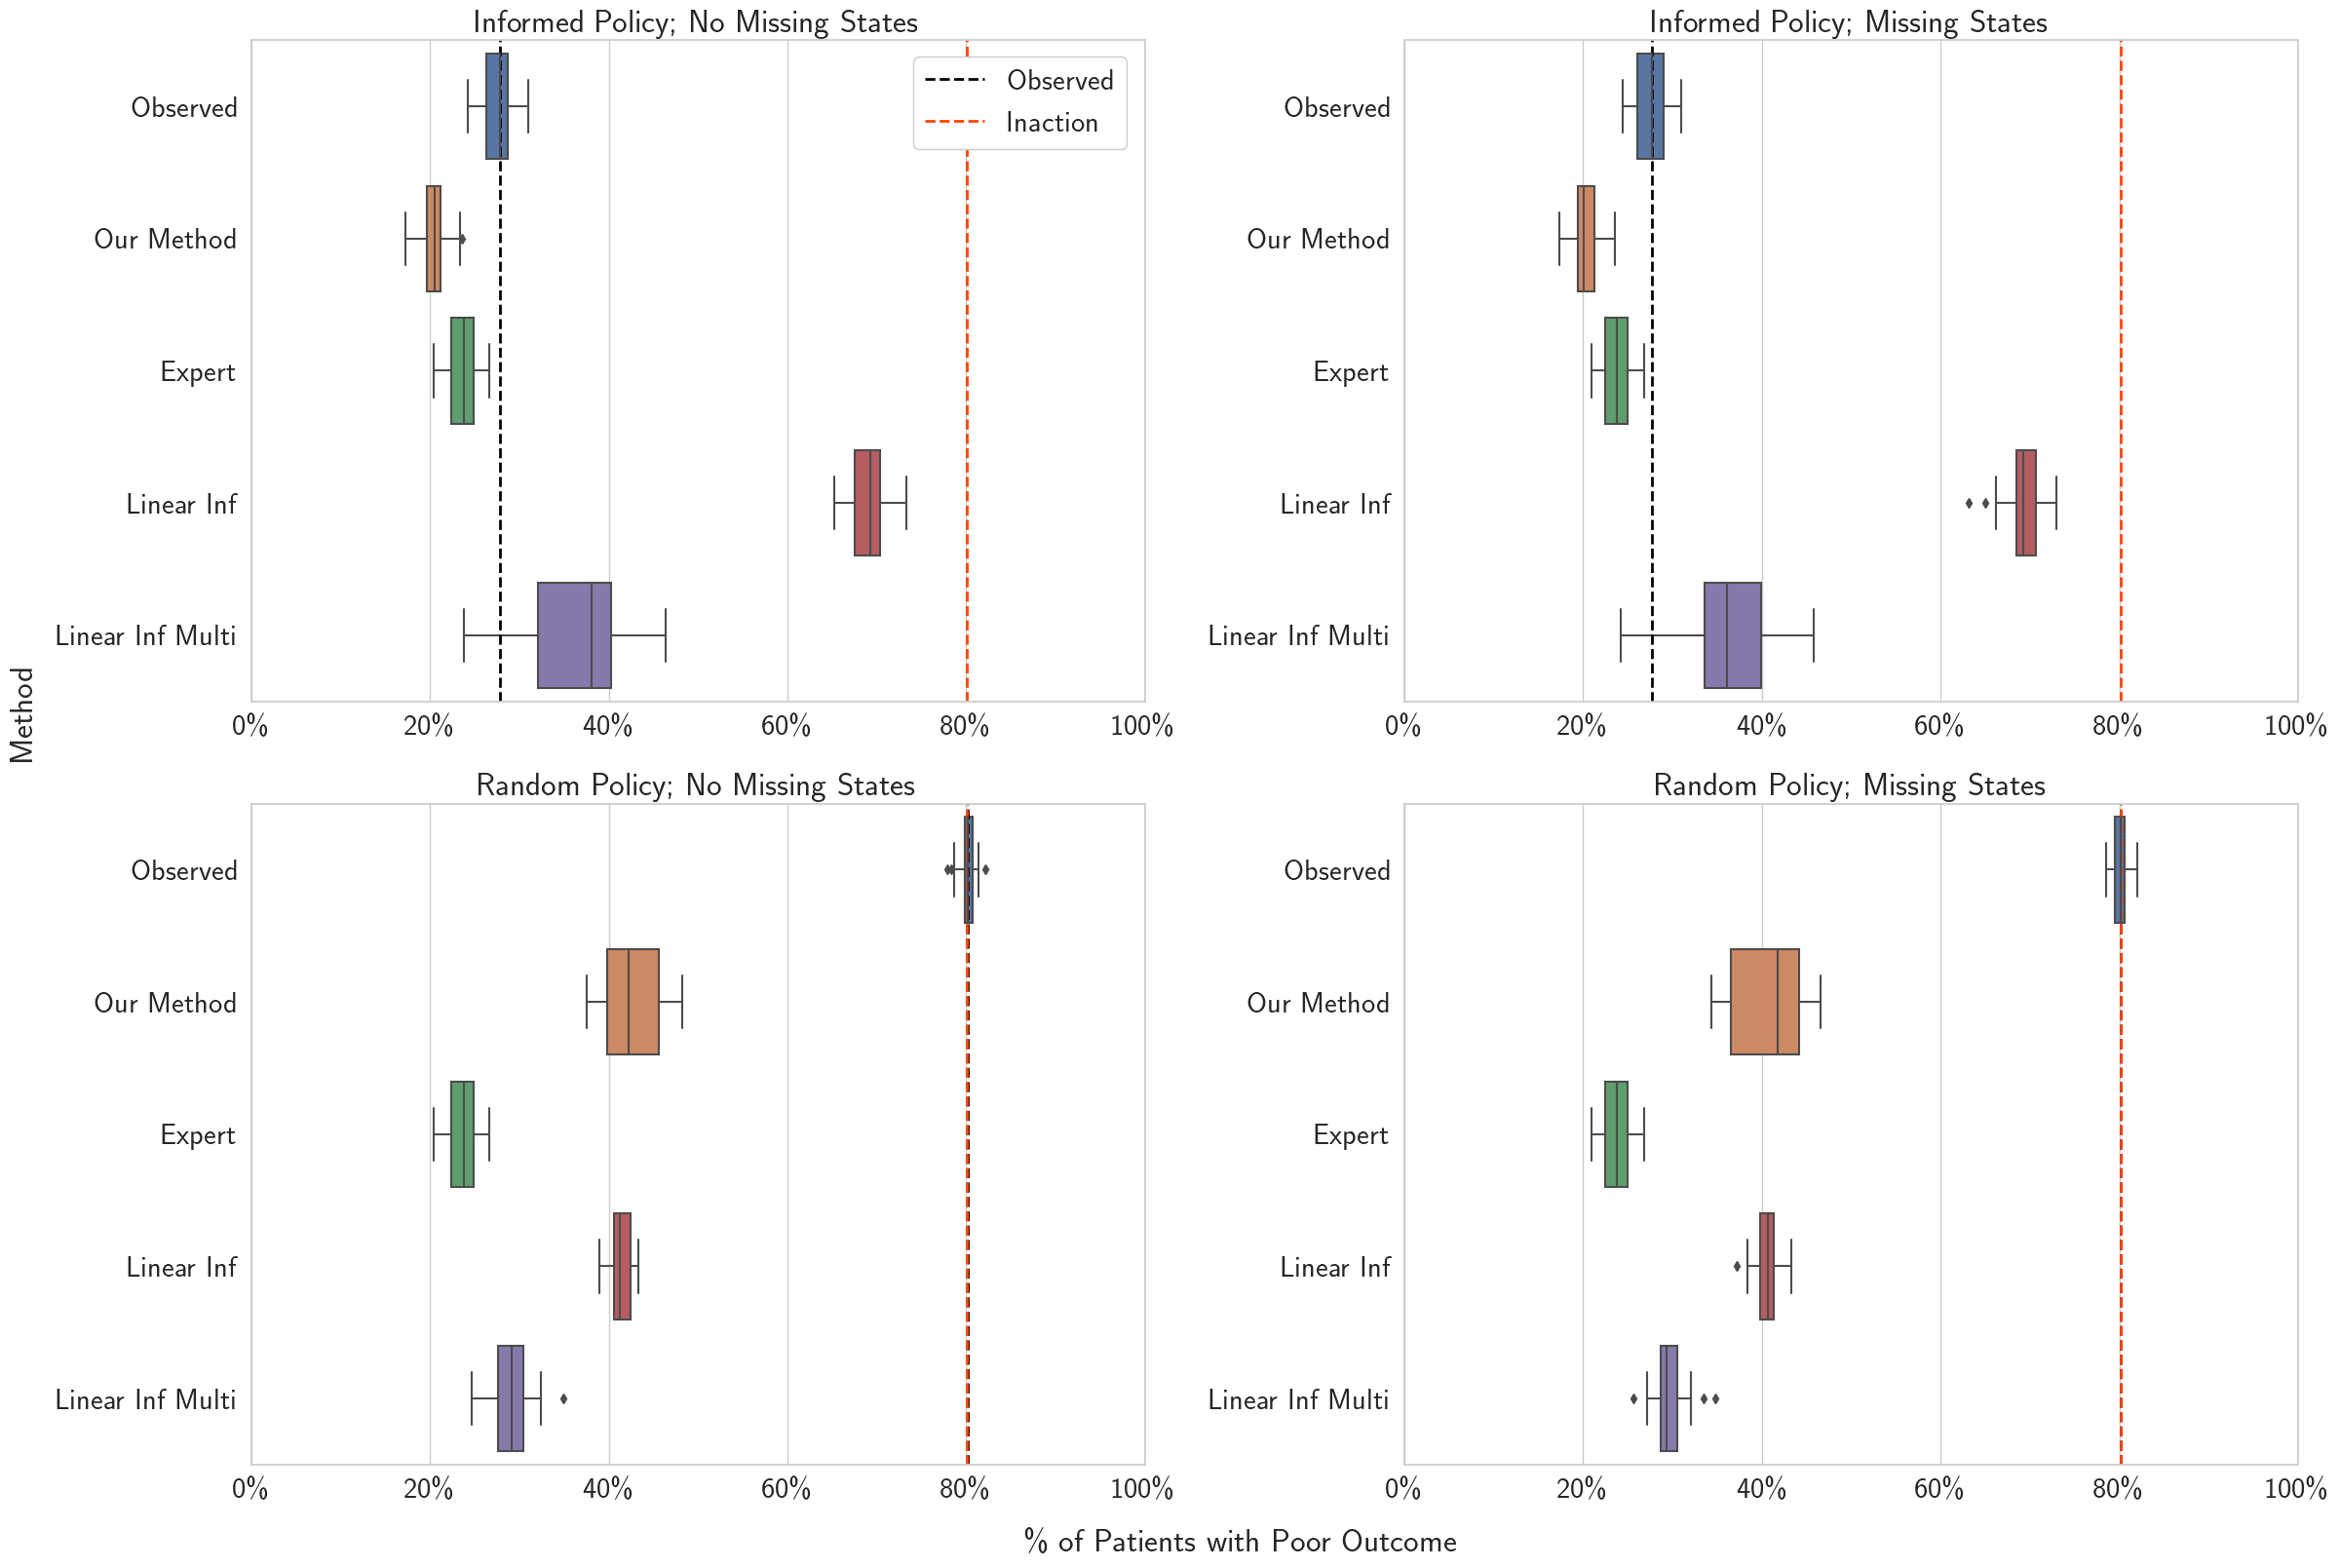

In [12]:
# Figure 9 in Appendix

covs = 100
t_setting = 'b'
binary_dose = False

rename = {'Linear Q-learning (R)': 'Linear Q-learning',
         'Linear Inf R3': 'Linear Inf',
         'Linear Inf Multi R3': 'Linear Inf Multi'}
methods = ['Observed', 'Our Method', 'Expert', 'Linear Inf', 'Linear Inf Multi']

sns.set(style='whitegrid', font_scale=2)
fig, ax = plt.subplots(2, 2, figsize=(24, 16))
d = 0
for dgp in ['informed', 'random']:
    t = 0
    while t < 2:
        if t == 0:
            t_drop_setting = 'a'
            title = dgp.capitalize()
            title = title + ' Policy; No Missing States'
        else:
            t_drop_setting = 'b'
            title = dgp.capitalize()
            title = title + ' Policy; Missing States'
        
        this_df = get_plot_df(full_df_bin, covs, t_setting, t_drop_setting, dgp, binary_dose)
        obs_med, inact_med = get_median_val(this_df, 'Observed'), get_median_val(this_df, 'Inaction')
        this_df = this_df.rename(columns=rename)
        this_df = this_df[methods].melt()
        this_df['value'] *= 100
        p = sns.boxplot(data=this_df, x='value', y='variable', orient='h', ax=ax[d,t])
        ax[d,t].set_xlabel('% of Patients with Poor Outcome')
        ax[d,t].set_ylabel('')
        ax[d,t].set_title(title)
        ax[d,t].axvline(x=obs_med, color='black', linestyle='--', label='Observed', linewidth=2)
        ax[d,t].axvline(x=inact_med, color='orangered', linestyle='--', label='Inaction', linewidth=2)
        ax[d,t].set_xlim([0, 100])
        ax[d,t].xaxis.set_major_formatter(mtick.PercentFormatter())
        handles, labels = ax[d,t].get_legend_handles_labels()        
        
        t += 1
    d += 1


fig.text(0, 0.5, 'Method', ha='center', rotation=90)
fig.text(0.52, -0.01, '\% of Patients with Poor Outcome', ha='center')
fig.legend(handles, ['Observed', 'Inaction'], loc=(0.39, 0.905), facecolor='white', framealpha=1)


plt.tight_layout(pad=1.0) 
plt.savefig(f'{filepath}/inf_binary_vs_multi.png', bbox_inches="tight")    
plt.show()

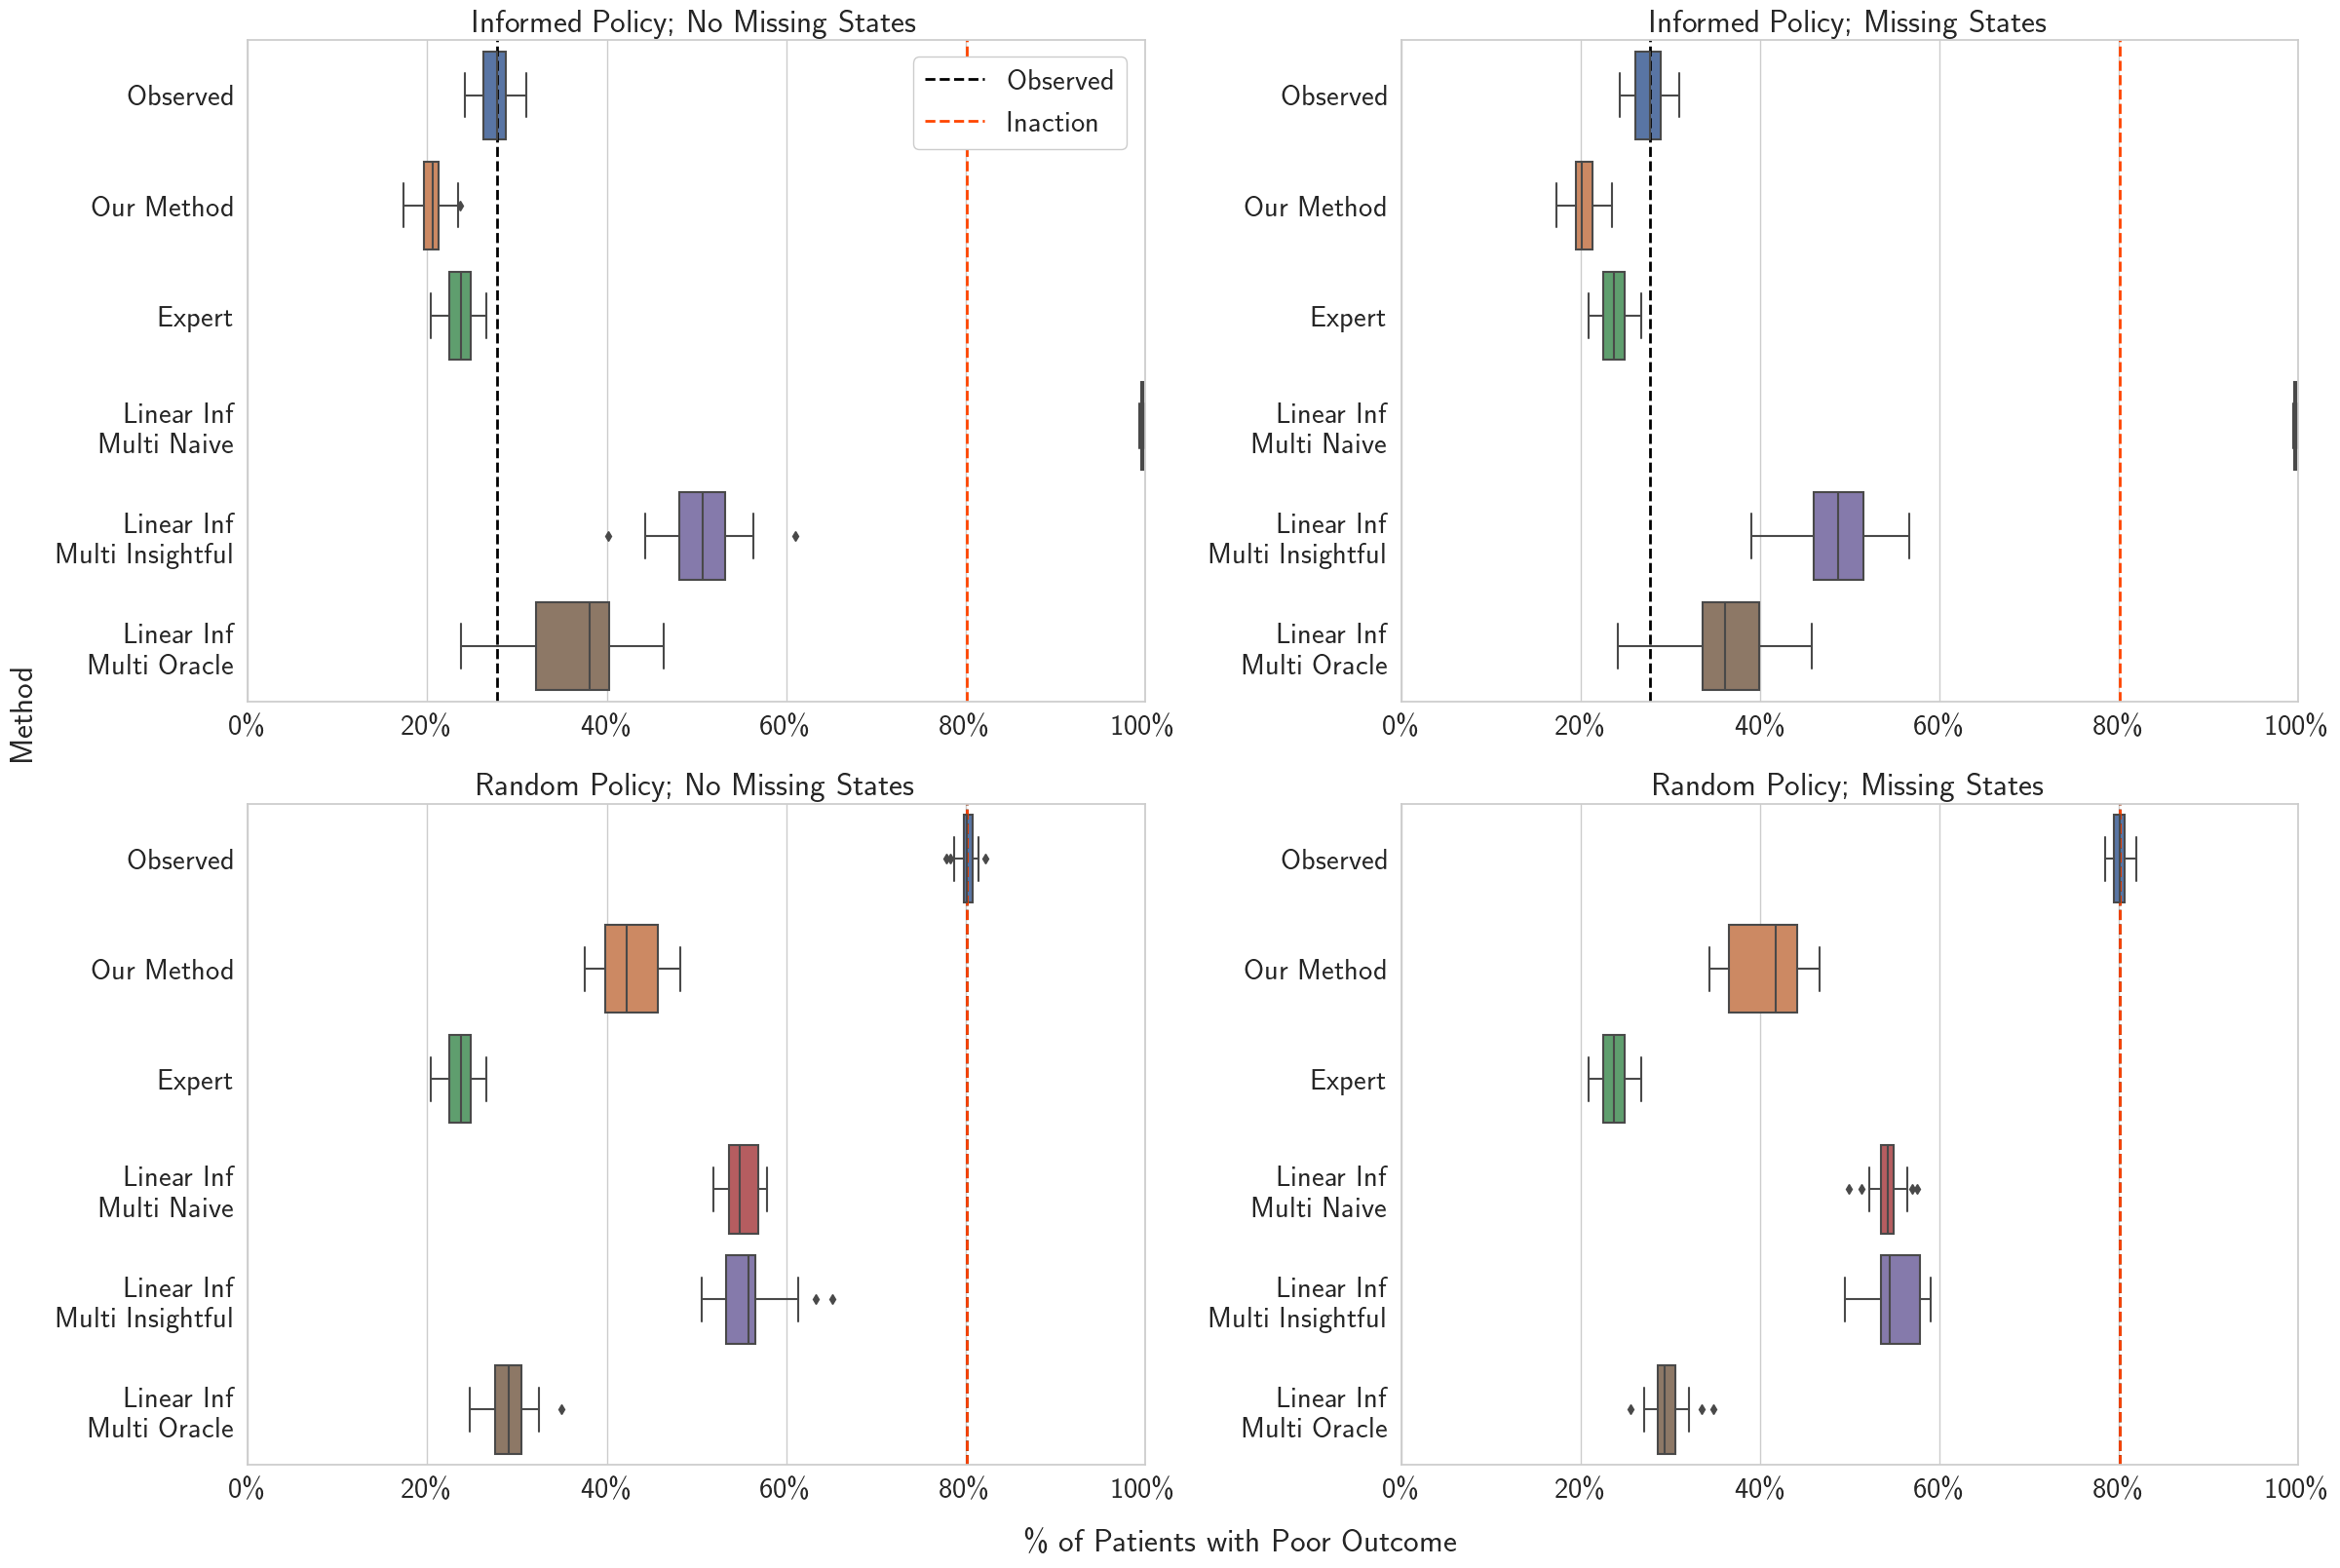

In [13]:
# Figure 10 in Appendix

covs = 100
t_setting = 'b'
binary_dose = False

rename = {'Linear Inf Multi R1': 'Linear Inf\nMulti Naive',
         'Linear Inf Multi R2': 'Linear Inf\nMulti Insightful',
         'Linear Inf Multi R3': 'Linear Inf\nMulti Oracle'}
methods = ['Observed', 'Our Method', 'Expert', 'Linear Inf\nMulti Naive', 
           'Linear Inf\nMulti Insightful', 'Linear Inf\nMulti Oracle']


sns.set(style='whitegrid', font_scale=2)
fig, ax = plt.subplots(2, 2, figsize=(24, 16))
d = 0
for dgp in ['informed', 'random']:
    t = 0
    while t < 2:
        if t == 0:
            t_drop_setting = 'a'
            title = dgp.capitalize()
            title = title + ' Policy; No Missing States'
        else:
            t_drop_setting = 'b'
            title = dgp.capitalize()
            title = title + ' Policy; Missing States'
        
        this_df = get_plot_df(full_df_bin, covs, t_setting, t_drop_setting, dgp, binary_dose)
        obs_med, inact_med = get_median_val(this_df, 'Observed'), get_median_val(this_df, 'Inaction')
        this_df = this_df.rename(columns=rename)
        this_df = this_df[methods].melt()
        this_df['value'] *= 100
        p = sns.boxplot(data=this_df, x='value', y='variable', orient='h', ax=ax[d,t])
        ax[d,t].set_xlabel('% of Patients with Poor Outcome')
        ax[d,t].set_ylabel('')
        ax[d,t].set_title(title)
        ax[d,t].axvline(x=obs_med, color='black', linestyle='--', label='Observed', linewidth=2)
        ax[d,t].axvline(x=inact_med, color='orangered', linestyle='--', label='Inaction', linewidth=2)
        ax[d,t].set_xlim([0, 100])
        ax[d,t].xaxis.set_major_formatter(mtick.PercentFormatter())
        handles, labels = ax[d,t].get_legend_handles_labels()        
        
        t += 1
    d += 1


fig.text(0, 0.5, 'Method', ha='center', rotation=90)
fig.text(0.52, -0.01, '\% of Patients with Poor Outcome', ha='center')
fig.legend(handles, ['Observed', 'Inaction'], loc=(0.39, 0.905), facecolor='white', framealpha=1)


plt.tight_layout(pad=1.0) 
plt.savefig(f'{filepath}/inf_reward_comp.png', bbox_inches="tight")    
plt.show()

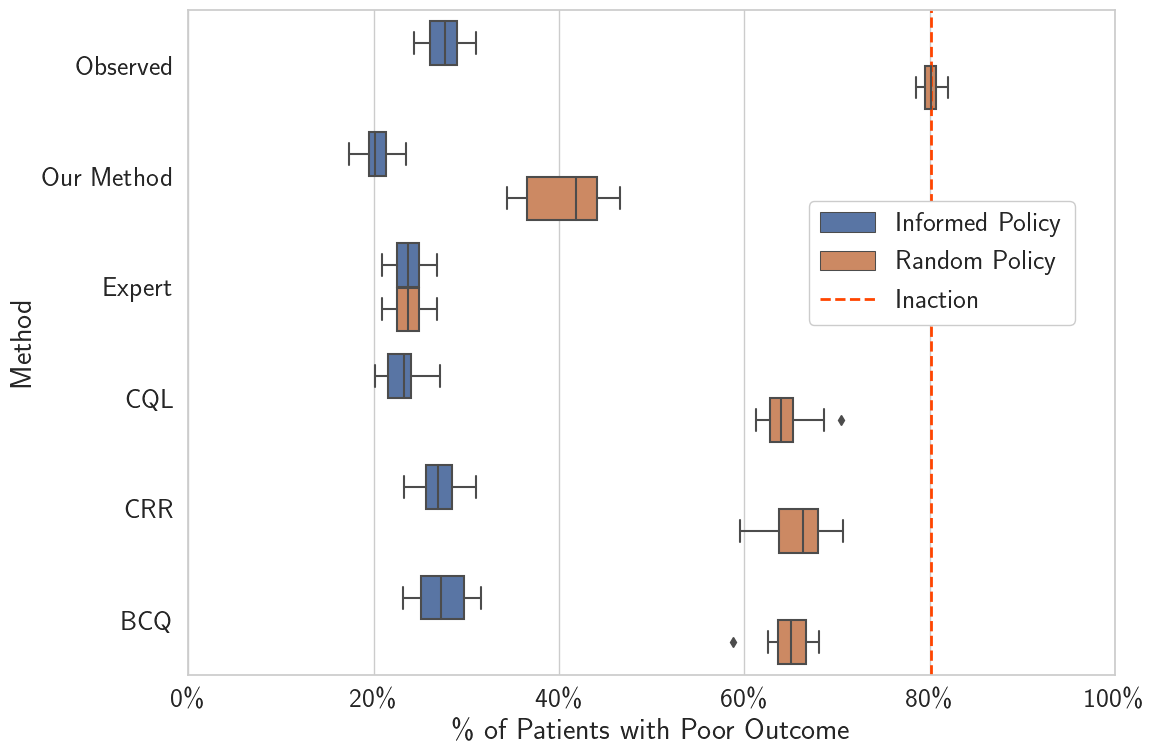

In [14]:
# Figure 11 in Appendix

covs = 100
t_setting = 'b'
t_drop_setting = 'b'
binary_dose = False

rename = {'DGP': "Policy Type",
          'CQL R2': 'CQL', 
          'CRR R2': 'CRR', 
          'BCQ R2': 'BCQ'
         }
methods = ['Policy Type', 'Observed', 'Our Method', 'Expert', 'CQL', 'CRR', 'BCQ']


sns.set(style='whitegrid', font_scale=1.8)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
this_df = get_plot_df(full_df_bin, covs, t_setting, t_drop_setting, dgp=None, binary_dose=binary_dose)
inact_med = get_median_val(this_df, 'Inaction')
this_df = this_df.rename(columns=rename)
this_df['Policy Type'] = this_df['Policy Type'].apply(lambda x: x.capitalize())
this_df = this_df.sort_values('Binary Dose', ascending=False)[methods].melt(id_vars=['Policy Type'])
this_df['value'] *= 100
p = sns.boxplot(data=this_df, x='value', y='variable', orient='h', ax=ax, hue='Policy Type')
ax.set_xlabel('\% of Patients with Poor Outcome')
ax.set_ylabel('Method')
ax.axvline(x=inact_med, color='orangered', linestyle='--', label='Inaction', linewidth=2)
ax.set_xlim([0, 100])
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
fig.legend(handles, ['Informed Policy', 'Random Policy', 'Inaction'], loc=(0.7, 0.57), facecolor='white', framealpha=1)
fig.tight_layout()
fig.savefig(f'{filepath}/deep_rl_policy_type.png')
plt.show()

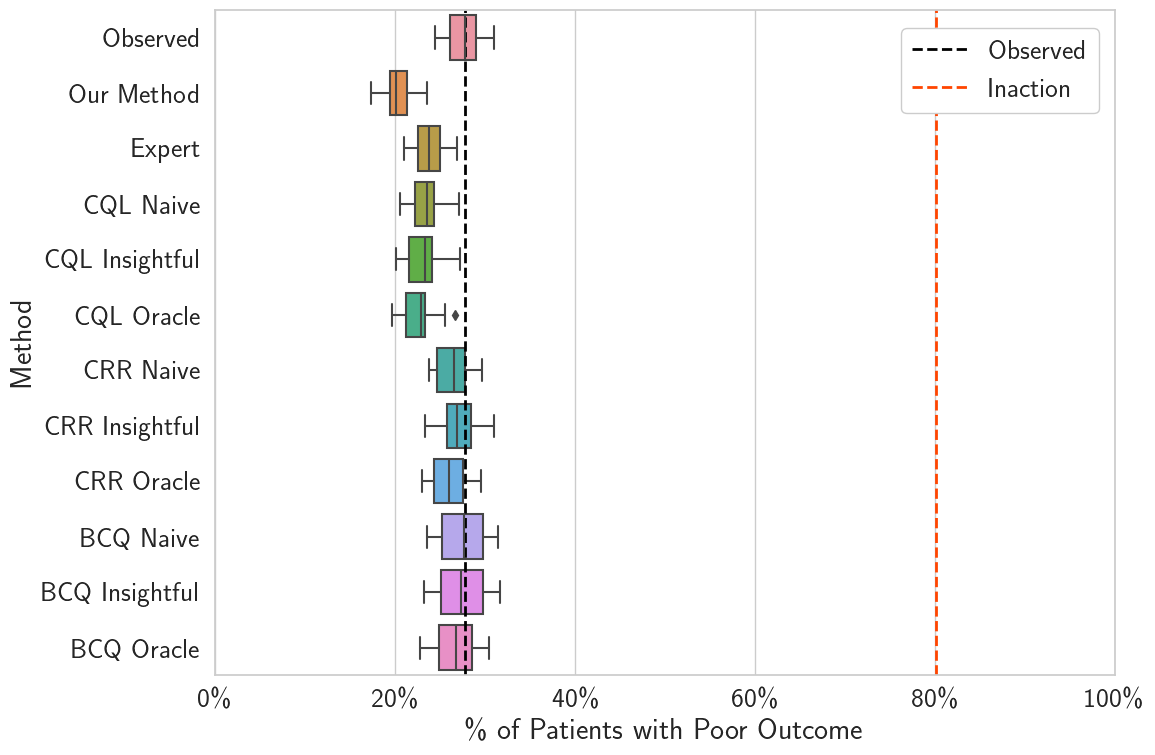

In [15]:
# Figure 12 in Appendix

covs = 100
binary_dose = False
t_setting = 'b'
t_drop_setting = 'b'
dgp = 'informed'

rename = {}
for m in ['CQL', 'CRR', 'BCQ']:
    for k,v in {'R1': 'Naive', 'R2': 'Insightful', 'R3': 'Oracle'}.items():
        rename[m + ' ' + k] = m + ' ' + v
methods = ['Observed', 'Our Method', 'Expert'] + [l for s in [[m + r for r in [' Naive', ' Insightful', ' Oracle']] for m in ['CQL', 'CRR', 'BCQ']] for l in s]

sns.set(style='whitegrid', font_scale=1.8)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
this_df = get_plot_df(full_df_bin, covs, t_setting, t_drop_setting, dgp, binary_dose)
obs_med, inact_med = get_median_val(this_df, 'Observed'), get_median_val(this_df, 'Inaction')
this_df = this_df.rename(columns=rename)[methods].melt()
this_df['value'] *= 100
p = sns.boxplot(data=this_df, x='value', y='variable', orient='h', ax=ax)
ax.set_xlabel('\% of Patients with Poor Outcome')
ax.set_ylabel('Method')
ax.axvline(x=obs_med, color='black', linestyle='--', label='Observed', linewidth=2)
ax.axvline(x=inact_med, color='orangered', linestyle='--', label='Inaction', linewidth=2)
ax.set_xlim([0, 100])
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, ['Observed', 'Inaction'], loc=(0.78, 0.85), facecolor='white', framealpha=1)
plt.tight_layout()    
plt.savefig(f'{filepath}/deep_reward_comp.png')    
plt.show()

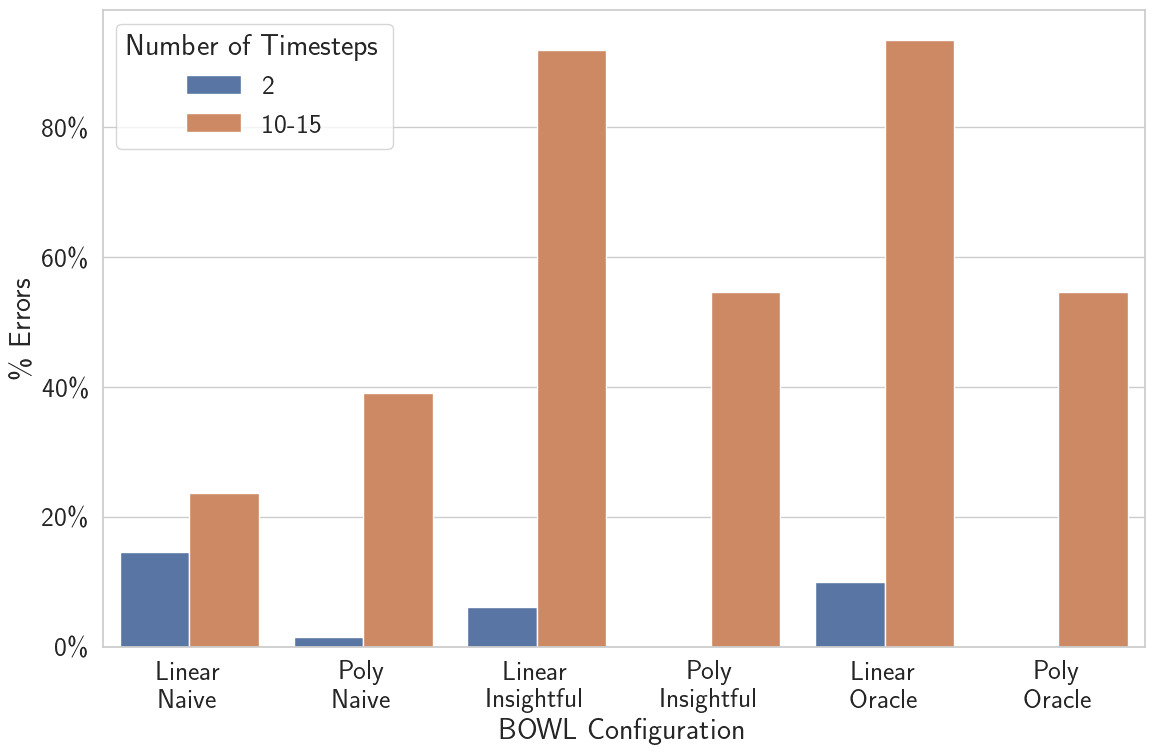

In [16]:
# Figure 13 in Appendix

rename = {}
for m in ['Poly BOWL', 'Linear BOWL']:
    for k,v in {'R1': 'Naive', 'R2': 'Insightful', 'R3': 'Oracle'}.items():
        rename[m + ' ' + k] = m.replace('BOWL', '') + '\n' + v
    
methods = [l for s in [[m + r for m in ['Linear BOWL', 'Poly BOWL']] for r in [' R1', ' R2', ' R3']] for l in s]
this_df = 100*full_df_nan.groupby(['T Setting']).sum()[methods] / ((full_df_nan.shape[0] / 2)*20)
this_df = this_df.rename(columns=rename)

this_df = this_df.reset_index().rename(columns={'T Setting': '# of Timesteps'})
this_df['Number of Timesteps'] = this_df['# of Timesteps'].apply(lambda x: '2' if x == 'a' else '10-15')
this_df = this_df.drop(columns=['# of Timesteps'])
this_df = this_df.melt(id_vars=['Number of Timesteps'])
this_df = this_df.rename(columns={'value': '\% Errors', 'variable': 'BOWL Configuration'})

sns.set(style='whitegrid', font_scale=1.8)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
p = sns.barplot(data=this_df, x='BOWL Configuration', y='\% Errors', hue='Number of Timesteps')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.savefig(f'{filepath}/bowl_nan.png')
plt.show()